In [1]:
import polars as pl
import numpy as np
import pickle
from typing import List
from itertools import chain, combinations

In [2]:
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLMResults
from statsmodels.genmod.families import family

In [3]:
import graphviz
import networkx as nx
from cdt.data import AcyclicGraphGenerator
import scipy

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [143]:
class TestingRound:
    iterations = 0
    last_deviance = None
    deviance = 0
    convergence_threshold = 1e-8
    rss = None
    llf = None
    total_samples = None
    
    def __init__(self, y_label, X_labels):
        self.y_label = y_label
        self.X_labels = X_labels
        self._init_beta0()
        
    def __eq__(self, t):
        assert type(t) == TestingRound
        return self.y_label == t.y_label and self.X_labels == t.X_labels   
    
    def __repr__(self):
        return f'TestingRound - y: {self.y_label}, X: {self.X_labels}, total samples: {self.total_samples}, beta: {self.beta}, current iteration: {self.iterations}, current deviance: {abs(self.deviance)}, relative deviance change: {abs(self.deviance - self.last_deviance) / (0.1 + abs(self.deviance)) if self.last_deviance is not None else "?"}, llf: {self.llf}, rss: {self.rss}' 
    
    def _init_beta0(self):
        #self.beta = np.random.randn(len(self.X_labels) + 1) # +1 for intercept
        self.beta = np.zeros(len(self.X_labels) + 1) # +1 for intercept
    
    def aggregate_results(self, results):
        results1, results2, deviances, llfs, rss, num_samples = zip(*results)
        #print('---')
        #print(np.linalg.inv(sum(results1)))
        #for r in results2:
        #    print(r)
        #print(sum(results2))
        self.beta = np.linalg.inv(sum(results1)) @ sum(results2)
        self.last_deviance = self.deviance
        self.deviance = sum(deviances)
        self.llf = sum(llfs)
        self.rss = sum(rss)
        self.total_samples = sum(num_samples)
        self.iterations += 1
        
        return abs(self.deviance - self.last_deviance) / (0.1 + abs(self.deviance)) < self.convergence_threshold


    
class TestingEngine:
    testing_rounds = []
    finished_rounds = []
    
    def __init__(self, available_data, max_regressors=None, max_iterations=25, save_steps=10):
        self.available_data = available_data
        self.max_regressors = max_regressors
        self.max_iterations = max_iterations
        self.save_steps = save_steps
        
        _max_conditioning_set_size = min(len(self.available_data)-1, self.max_regressors) if self.max_regressors is not None else len(self.available_data)-1
        
        for y_var in available_data:
            set_of_regressors = available_data - {y_var}
            #for x_var in set_of_regressors:
            #set_of_conditioning_variables = set_of_regressors - {x_var}
            powerset_of_regressors = chain.from_iterable(combinations(set_of_regressors, r) for r in range(0,_max_conditioning_set_size+1))
            #self.testing_rounds.append(TestingRound(y_label=y_var, X_labels=[])) # null model (intercept only)
            #self.testing_rounds.append(TestingRound(y_label=y_var, X_labels=[x_var]))
            self.testing_rounds.extend([TestingRound(y_label=y_var, X_labels=sorted(list(x_vars))) for x_vars in powerset_of_regressors])
            
        self.testing_rounds = sorted(self.testing_rounds, key=lambda key: len(key.X_labels))
        self.is_finished = len(self.testing_rounds) == 0
            
    def get_current_test_parameters(self):
        curr_testing_round = self.testing_rounds[0]
        return curr_testing_round.y_label, curr_testing_round.X_labels, curr_testing_round.beta
    
    def finish_current_test(self):
        self.finished_rounds.append(self.testing_rounds.pop(0))
        self.is_finished = len(self.testing_rounds) == 0
        
    def aggregate_results(self, results):
        has_converged = self.testing_rounds[0].aggregate_results(results)
        has_reached_max_iterations = self.testing_rounds[0].iterations >= self.max_iterations
        #print(self.testing_rounds[0])
        if has_converged or has_reached_max_iterations:
            self.finish_current_test()
        

class Server:
    clients = {}
    
    def __init__(self, clients, max_regressors=None):
        self.clients = clients
        self.available_data = set.union(*[set(c.data_labels) for c in self.clients.values()])
        self.testing_engine = TestingEngine(self.available_data, max_regressors=max_regressors)
        
    def run_tests(self):
        counter = 1
        while not self.testing_engine.is_finished:
            y_label, X_labels, beta = self.testing_engine.get_current_test_parameters()
            selected_clients = {id_: c for id_, c in self.clients.items() if set([y_label] + X_labels).issubset(c.data_labels)}
            # http response, to compute glm results for y regressed on X with beta
            results = [c.compute(y_label, X_labels, beta) for c in selected_clients.values()]
            self.testing_engine.aggregate_results(results)
            if counter % self.testing_engine.save_steps == 0:
                counter = 0
                with open('./testengine.ckp', 'wb') as f:
                    pickle.dump(self.testing_engine, f)
            counter += 1
                
    
class Client:
    def __init__(self, data):
        self.data = data
        self.data_labels = data.columns
        
        
    def compute(self, y_label: str, X_labels: List[str], beta):
        y = self.data[y_label]
        X = self.data[X_labels]
        
        X = X.to_numpy()
        X = sm.tools.add_constant(X)
                
        eta, mu, dmu_deta, deviance, llf, rss = self._init_compute(y,X,beta)
        
        #print('eta', eta)
        #print('mu', mu)
        #print('dmu/deta', dmu_deta)
        
        z = eta + (y - mu)/dmu_deta
        W = np.diag((dmu_deta**2)/max(np.var(mu), 1e-8))
        
        #print(z)
        
        r1 = X.T @ W @ X
        r2 = X.T @ W @ z
        
        
        # TODO: r1 und r2 immer gleich, egal welches beta
        
        #print('r1', r1)
        #print('r2', r2)
        
        return r1, r2, deviance, llf, rss, len(y)
        
        
    def _init_compute(self, y, X, beta):
        glm_model = sm.GLM(y, X, family=family.Gaussian())
        normalized_cov_params = np.linalg.inv(X.T.dot(X))
        scale = glm_model.fit().scale
        glm_results = GLMResults(glm_model, beta, normalized_cov_params=normalized_cov_params, scale=None)
        
        # GLMResult with correct scale
        #scale = glm_model.estimate_scale(glm_results.predict(which='linear'))
        #glm_results = GLMResults(glm_model, beta, normalized_cov_params=normalized_cov_params, scale=scale)
        
        eta = glm_results.predict(which='linear')
        
        # g' is inverse of link function
        inverse_link = glm_results.family.link.inverse
        mu = inverse_link(eta)
        
        deviance = glm_results.deviance
        
        # delta g' is derivative of inverse link function
        derivative_inverse_link = glm_results.family.link.inverse_deriv
        dmu_deta = derivative_inverse_link(eta)
        return eta, mu, dmu_deta, deviance, glm_results.llf, sum((eta-y)**2)
    

In [144]:
class LikelihoodRatioTest:
    def __init__(self, t0: TestingRound, t1: TestingRound) -> None:
        
        assert t0.y_label == t1.y_label
        self.t0 = t0
        self.t1 = t1
        
        if len(t0.X_labels) == 0 and len(t1.X_labels) == 1:
            self.y_label = self.t0.y_label
            self.x_label = self.t1.X_labels[0]
            self.s_labels = []
        else:
            assert len(t0.X_labels) == 1
            assert len(t1.X_labels) > 1
            assert t0.X_labels[0] in t1.X_labels
            
            self.y_label = self.t0.y_label
            self.x_label = self.t0.X_labels[0] if len(t0.X_labels) > 0 else None
            self.s_labels = sorted(list(set(self.t1.X_labels) - {self.x_label})) if t1 is not None else []
        
        #self.p_val = self._run_f_test()
        self.p_val = self._run_likelihood_test()
        
    def __repr__(self):
        return f"LikelihoodRatioTest - y: {self.y_label}, x: {self.x_label}, S: {self.s_labels}, p: {self.p_val}"
    
    def _run_likelihood_test(self):
        t = -2*(self.t0.llf - self.t1.llf)
        
        par0 = len(self.t0.X_labels) + 1 # + intercept
        par1 = len(self.t1.X_labels) + 1 # + intercept
        
        p_val = scipy.stats.chi2.sf(t, par1-par0)
        
        return p_val
        
    def _run_f_test(self):
        rss0 = self.t0.rss
        rss1 = self.t1.rss
        par0 = 2 # X + intercept
        par1 = len(self.s_labels) + 2 # + X + intercepts
        nobs = self.t0.total_samples
        delta_rss = rss0 - rss1
        dfn = par1 - par0
        dfd = nobs - par1
        
        f = delta_rss*dfd/rss1/dfn
        
        # print(nobs)
        # print(rss0, rss1)
        # print(dfn, dfd)
        # print(f)
        # print('-'*15)
        
        p_val = scipy.stats.f.sf(f, dfn, dfd)
        
        return p_val

In [145]:
class SymmetricLikelihoodRatioTest:
    
    def __init__(self, lrt0: LikelihoodRatioTest, lrt1: LikelihoodRatioTest):
        
        assert lrt0.y_label == lrt1.x_label or lrt1.x_label is None
        assert lrt1.y_label == lrt0.x_label or lrt0.x_label is None
        
        
        #print(lrt0.s_labels, lrt1.s_labels)
        assert lrt0.s_labels.sort() == lrt1.s_labels.sort()
        
        self.label1 = lrt0.y_label
        self.label2 = lrt1.y_label
        self.conditioning_set = lrt0.s_labels
        
        self.lrt0: LikelihoodRatioTest = lrt0
        self.lrt1: LikelihoodRatioTest = lrt1
        
        self.p_val = min(2*min(self.lrt0.p_val, self.lrt1.p_val), max(self.lrt0.p_val, self.lrt1.p_val))
        
    def __repr__(self):
        #return f"SymmetricLikelihoodRatioTest - v0: {self.label1}, v1: {self.label2}, conditioning set: {self.conditioning_set}"
        return f"SymmetricLikelihoodRatioTest - v0: {self.label1}, v1: {self.label2}, conditioning set: {self.conditioning_set}\n\t-{self.lrt0}\n\t-{self.lrt1}"

In [146]:
# TODO: MAJOR PROBLEM WHEN SET OF REGRESSORS EXISTS FOR MORE CLIENTS IN t0 THEN THEY DO FOR t1. SCREWS RSS AND NUM SAMPLES.
# TODO: KEEP RESULTS MAPPED TO CLIENTS AND USE ONLY RESULTS OF INTERSECTION

In [147]:
# RANDOM DATA GENERATION PROCESS

In [148]:
# generate: try rescale=False and rescale=True (default)

In [149]:
NUM_CLIENTS = 3
TOTAL_FEATURES = 4
FEATURES_PER_CLIENT = 4

In [150]:
generator = AcyclicGraphGenerator('linear', npoints=900, nodes=TOTAL_FEATURES)
data, graph = generator.generate()
#generator.to_csv('generated_graph')

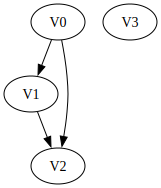

In [151]:
dag = graphviz.Source(nx.nx_agraph.to_agraph(graph).to_string())
# dag.render('target_graph')
dag

In [152]:
data_splits = np.array_split(data, NUM_CLIENTS)

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.


In [153]:
selected_data_splits = []
for data_split in data_splits:
    drop_cols = list(np.random.choice(data_split.columns, TOTAL_FEATURES-FEATURES_PER_CLIENT, replace=False))
    selected_data_splits.append(data_split.drop(drop_cols, axis=1))
data_splits = selected_data_splits
del selected_data_splits

In [154]:
clients = {i:Client(data_split) for i,data_split in enumerate(data_splits)}

In [155]:
server = Server(clients)

In [156]:
server.run_tests()

In [157]:
server.testing_engine.finished_rounds

[TestingRound - y: V1, X: [], total samples: 900, beta: [-1.27156576e-16], current iteration: 2, current deviance: 900.0, relative deviance change: 0.0, llf: -1271.651326802688, rss: 900.0,
 TestingRound - y: V0, X: [], total samples: 900, beta: [-1.69542101e-16], current iteration: 2, current deviance: 900.0000000000002, relative deviance change: 0.0, llf: -1270.864947850766, rss: 900.0000000000002,
 TestingRound - y: V3, X: [], total samples: 900, beta: [1.21858385e-16], current iteration: 2, current deviance: 900.0, relative deviance change: 0.0, llf: -1073.888328981216, rss: 899.9999999999999,
 TestingRound - y: V2, X: [], total samples: 900, beta: [2.11927626e-17], current iteration: 2, current deviance: 899.9999999999998, relative deviance change: 0.0, llf: -1272.9138389003733, rss: 899.9999999999993,
 TestingRound - y: V1, X: ['V2'], total samples: 900, beta: [0.00202489 0.92534071], current iteration: 4, current deviance: 130.16596684383177, relative deviance change: 0.0, llf: 

In [161]:
finished_testing_rounds = server.testing_engine.finished_rounds

av_data = server.testing_engine.available_data

tr = {}
null_models = {}
for y_var in av_data:
    null_models[y_var] = [t for t in finished_testing_rounds if t.y_label == y_var and len(t.X_labels) == 0][0]
    for x_var in av_data - {y_var}:
        x_testings = {}
        x_testings['base'] = [t for t in finished_testing_rounds if t.y_label == y_var and x_var in t.X_labels and len(t.X_labels) == 1][0]
        x_testings['conditioning'] = [t for t in finished_testing_rounds if t.y_label == y_var and x_var in t.X_labels and len(t.X_labels) > 1]
        x_testings['conditioning'] = sorted(x_testings['conditioning'], key=lambda x: ','.join(x.X_labels))
        tr[(y_var, x_var)] = x_testings

In [162]:
tr[('V2', 'V1')]['conditioning']

[TestingRound - y: V2, X: ['V0', 'V1'], total samples: 900, beta: [-2.70705196e-05  3.03941688e-01  6.33755984e-01], current iteration: 4, current deviance: 123.32047278566463, relative deviance change: 2.4883532705416985e-09, llf: -381.4903632076845, rss: 123.32047278566462,
 TestingRound - y: V2, X: ['V0', 'V1', 'V3'], total samples: 900, beta: [ 3.96056176e-05  3.05554826e-01  6.32799159e-01 -1.14179184e-02], current iteration: 4, current deviance: 123.20197782083208, relative deviance change: 1.575377636071039e-09, llf: -380.97640135400945, rss: 123.20197782083204,
 TestingRound - y: V2, X: ['V1', 'V3'], total samples: 900, beta: [ 1.35131368e-04  9.25237394e-01 -8.60534568e-03], current iteration: 4, current deviance: 130.0975687016173, relative deviance change: 1.1663524679040423e-09, llf: -405.58947427936243, rss: 130.09756870161726]

In [163]:
tr[('V1', 'V2')]['conditioning']

[TestingRound - y: V1, X: ['V0', 'V2'], total samples: 900, beta: [-5.62042390e-04  6.78265688e-01  3.07804217e-01], current iteration: 5, current deviance: 59.93635462962055, relative deviance change: 6.422730597504438e-12, llf: -57.646968569627695, rss: 59.93635462962055,
 TestingRound - y: V1, X: ['V0', 'V2', 'V3'], total samples: 900, beta: [-5.65562468e-04  6.78328713e-01  3.07765962e-01 -3.88517937e-04], current iteration: 5, current deviance: 59.93610345797652, relative deviance change: 1.1378558456092275e-10, llf: -57.646337864111665, rss: 59.93610345797653,
 TestingRound - y: V1, X: ['V2', 'V3'], total samples: 900, beta: [0.00173399 0.92455189 0.01553113], current iteration: 5, current deviance: 129.94949151162155, relative deviance change: 1.1846249775896874e-11, llf: -404.7715702566132, rss: 129.9494915116215]

In [164]:
likelihood_ratio_tests = []

unique_combinations = [k for k in tr.keys() if k[0] < k[1]]

for v0, v1 in unique_combinations:
    base_test0 = tr[(v0,v1)]['base']
    base_test1 = tr[(v1,v0)]['base']
    # null test
    lrt0 = LikelihoodRatioTest(null_models[v0], base_test0)
    lrt1 = LikelihoodRatioTest(null_models[v1], base_test1)
    likelihood_ratio_tests.append(SymmetricLikelihoodRatioTest(lrt0, lrt1))
    
    cond_tests0 = tr[(v0, v1)]['conditioning']
    cond_tests1 = tr[(v1, v0)]['conditioning']
    
    lrts0 = [LikelihoodRatioTest(base_test0, t) for t in cond_tests0]
    lrts1 = [LikelihoodRatioTest(base_test1, t) for t in cond_tests1]
    
    likelihood_ratio_tests.extend([SymmetricLikelihoodRatioTest(l0, l1) for l0, l1 in zip(lrts0, lrts1)])

In [165]:
likelihood_ratio_tests

[SymmetricLikelihoodRatioTest - v0: V1, v1: V2, conditioning set: []
 	-LikelihoodRatioTest - y: V1, x: V2, S: [], p: 0.0
 	-LikelihoodRatioTest - y: V2, x: V1, S: [], p: 0.0,
 SymmetricLikelihoodRatioTest - v0: V1, v1: V2, conditioning set: ['V0']
 	-LikelihoodRatioTest - y: V1, x: V2, S: ['V0'], p: 2.4742800751676956e-153
 	-LikelihoodRatioTest - y: V2, x: V1, S: ['V0'], p: 2.8521468786317094e-12,
 SymmetricLikelihoodRatioTest - v0: V1, v1: V2, conditioning set: ['V0', 'V3']
 	-LikelihoodRatioTest - y: V1, x: V2, S: ['V0', 'V3'], p: 8.186395183285156e-152
 	-LikelihoodRatioTest - y: V2, x: V1, S: ['V0', 'V3'], p: 1.522868581627445e-11,
 SymmetricLikelihoodRatioTest - v0: V1, v1: V2, conditioning set: ['V3']
 	-LikelihoodRatioTest - y: V1, x: V2, S: ['V3'], p: 0.21604399311506794
 	-LikelihoodRatioTest - y: V2, x: V1, S: ['V3'], p: 0.44259912965432047,
 SymmetricLikelihoodRatioTest - v0: V1, v1: V3, conditioning set: []
 	-LikelihoodRatioTest - y: V1, x: V3, S: [], p: 1.0
 	-Likelihoo

In [166]:
p_vals = [l.p_val for l in likelihood_ratio_tests]
min(p_vals), max(p_vals)

(0.0, 0.6073241874186389)

In [167]:
import matplotlib.pyplot as plt

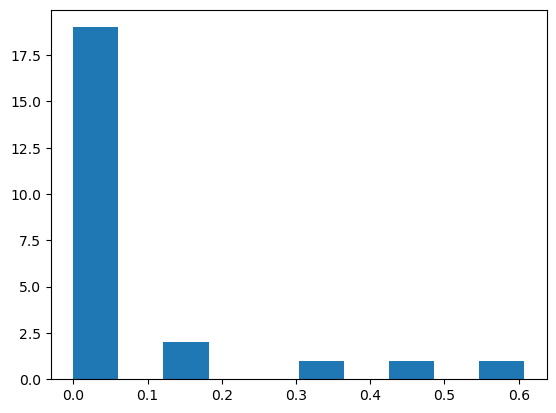

In [168]:
plt.hist(p_vals)
plt.show()

In [169]:
likelihood_ratio_tests[0]

SymmetricLikelihoodRatioTest - v0: V1, v1: V2, conditioning set: []
	-LikelihoodRatioTest - y: V1, x: V2, S: [], p: 0.0
	-LikelihoodRatioTest - y: V2, x: V1, S: [], p: 0.0

In [170]:
# TODO: HOW TO DO TEST WITHOUT CONDITIONING SET?

In [171]:
label2id_mapping = {l:i for i,l in enumerate(sorted(server.available_data), start=1)}

In [172]:
def lrt2pandas(lrts: List[SymmetricLikelihoodRatioTest], label2id_mapping):
    data = []
    for lrt in lrts:
        d = {}
        d['ord'] = len(lrt.conditioning_set)
        if lrt.label1 < lrt.label2:
            d['X'] = str(label2id_mapping[lrt.label1])
            d['Y'] = str(label2id_mapping[lrt.label2])
        else:
            d['X'] = str(label2id_mapping[lrt.label2])
            d['Y'] = str(label2id_mapping[lrt.label1])
        d['S'] = ','.join([str(label2id_mapping[l]) for l in lrt.conditioning_set])
        #d['S'] = list([label2id_mapping[l] for l in lrt.conditioning_set])
        d['pvalue'] = lrt.p_val
        data.append(d)
    return pl.from_dicts(data).unique().sort('ord', 'X', 'Y', 'S').to_pandas()

In [173]:
df = lrt2pandas(likelihood_ratio_tests, label2id_mapping)
df

,ord,X,Y,S,pvalue
0,0,1,2,,0.000000e+00
1,0,1,3,,0.000000e+00
2,0,1,4,,5.532416e-02
3,0,2,3,,0.000000e+00
4,0,2,4,,3.518520e-01
5,0,3,4,,1.739561e-01
6,1,1,2,3,3.195280e-44
7,1,1,2,4,6.073242e-01
8,1,1,3,2,3.207936e-153
9,1,1,3,4,1.719781e-01


In [174]:
#import os
#os.environ['R_HOME'] = '/opt/homebrew/Caskroom/miniforge/base/envs/promotion'

In [175]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from collections import OrderedDict

In [176]:
def run_local_fci(df, labels, alpha=0.05):
    #print(df)
    #print(labels)
    print('0.5')
    with (ro.default_converter + pandas2ri.converter).context():
        print('1')
        ro.r['source']('../scripts/aggregation.r')
        aggregate_ci_results_f = ro.globalenv['aggregate_ci_results']
        
        print('2')
        d = [('citestResults', ro.conversion.get_conversion().py2rpy(df)), ('labels', ro.StrVector(labels))]
        od = OrderedDict(d)
        lv = ro.ListVector(od)

        print('4')
        print(lv)

        result = aggregate_ci_results_f([lv], alpha)

        pag = [x[1].tolist() for x in result['G_PAG_List'].items()][0]
        pag_labels = [list(x[1]) for x in result['G_PAG_Label_List'].items()][0]
        
    return pag,pag_labels

In [177]:
labels = [str(v) for v in label2id_mapping.keys()]
labels

['V0', 'V1', 'V2', 'V3']

In [178]:
run_local_fci(df, labels)

0.5
1


R[write to console]: 
Attache Paket: ‘igraph’


R[write to console]: Die folgenden Objekte sind maskiert von ‘package:stats’:

    decompose, spectrum


R[write to console]: Das folgende Objekt ist maskiert ‘package:base’:

    union


R[write to console]: Lade nötiges Paket: graph

R[write to console]: Lade nötiges Paket: BiocGenerics

R[write to console]: 
Attache Paket: ‘BiocGenerics’


R[write to console]: Die folgenden Objekte sind maskiert von ‘package:igraph’:

    normalize, path, union


R[write to console]: Die folgenden Objekte sind maskiert von ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: Die folgenden Objekte sind maskiert von ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames

2
4
$citestResults
   ord X Y   S        pvalue
0    0 1 2      0.000000e+00
1    0 1 3      0.000000e+00
2    0 1 4      5.532416e-02
3    0 2 3      0.000000e+00
4    0 2 4      3.518520e-01
5    0 3 4      1.739561e-01
6    1 1 2   3  3.195280e-44
7    1 1 2   4  6.073242e-01
8    1 1 3   2 3.207936e-153
9    1 1 3   4  1.719781e-01
10   1 1 4   2  0.000000e+00
11   1 1 4   3  0.000000e+00
12   1 2 3   1 4.948560e-153
13   1 2 3   4  4.320880e-01
14   1 2 4   1  0.000000e+00
15   1 2 4   3  0.000000e+00
16   1 3 4   1  0.000000e+00
17   1 3 4   2  0.000000e+00
18   2 1 2 3,4  5.630634e-43
19   2 1 3 2,4 5.205923e-152
20   2 1 4 2,3  0.000000e+00
21   2 2 3 1,4 1.637279e-151
22   2 2 4 1,3  0.000000e+00
23   2 3 4 1,2  0.000000e+00

$labels
[1] "V0" "V1" "V2" "V3"


[1] "V0" "V1" "V2" "V3"
[1] 4
Order=0; remaining edges:12


R[write to console]: Fehler in names(x) <- value : 
  Attribut 'names' [5] muss dieselbe Länge haben wie der Vektor [0]



RRuntimeError: Fehler in names(x) <- value : 
  Attribut 'names' [5] muss dieselbe Länge haben wie der Vektor [0]


In [ ]:
!which R

/opt/homebrew/Caskroom/miniforge/base/envs/promotion/bin/R
